In [1]:
from pymatreader import read_mat
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import numpy as np
import librosa
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Input, Flatten, Dense, Reshape, SpatialDropout2D, MultiHeadAttention, Conv1D, Dropout
from keras.layers import LayerNormalization, AveragePooling1D, RepeatVector, Multiply, Concatenate,GlobalAveragePooling1D, Add, DepthwiseConv2D
import torch
from keras.losses import CosineSimilarity
from torch.utils.data import Dataset
import tensorflow as tf
torch.set_default_device('cuda')
from sklearn.preprocessing import scale
from torch.utils.data import Dataset, DataLoader
import more_itertools
from keras_pos_embd import TrigPosEmbedding
from scipy.signal import sosfiltfilt, butter
from scipy.signal import sosfiltfilt, butter

#from keras_nlp.layers import TransformerEncoder


#torch.backends.cudnn.benchmark = True

In [11]:
X = np.load('sub1.npy')
stim1 = np.load('stim.npy')
stim2 = np.load('mask.npy')
#label = read_mat('ExJobb/y.mat')['label'][0:4]%2
#label = np.repeat(label.reshape(-1,1),33,axis=1)

In [12]:
Xx = []
stimulus = []
masker = []
for i in range(80):
    x = []
    for j in range(66):
        t = np.array(list(more_itertools.sliced(X[i][j],n=128)))
        x.append(t.T)
    Xx.append(np.asarray(x).T)
    stimulus.append(np.array(list(more_itertools.sliced(stim1[i],n=128))))
    masker.append(np.array(list(more_itertools.sliced(stim2[i],n=128))))

X = np.array(Xx)
stim = np.array(stimulus)
mask = np.array(masker)

X = X.reshape((80*33,128,66))
stim = stim.reshape((80*33,128))
mask = mask.reshape((80*33,128))
#label = label.reshape((80*33,1))

In [13]:
X_train,X_valid,y_tr,y_val,m,mv = train_test_split(X,stim,mask,test_size=0.2)

In [14]:
y_tr.shape

(2112, 128)

In [15]:
trsc = StandardScaler()
X_tr = []
X_val = []
for i in range(len(X_train)):
    X_tr.append(np.expand_dims(trsc.fit_transform(X_train[i]),axis=-1).astype(np.float32))

for i in range(len(X_valid)):
    X_val.append(np.expand_dims(trsc.fit_transform(X_valid[i]),axis=-1).astype(np.float32))
#X_test = np.expand_dims(trsc.fit_transform(respts),axis=-1).astype(np.float32)

X_tr = np.array(X_tr)
X_val = np.array(X_val)

trst = StandardScaler()
y_tr = trst.fit_transform(y_tr.T).astype(np.float32).T
y_val = trst.fit_transform(y_val.T).astype(np.float32).T
#y_test = trst.fit_transform(stimts).astype(np.float32)

trsm = StandardScaler()
m_tr = trsm.fit_transform(m.T).astype(np.float32).T
m_val = trsm.fit_transform(mv.T).astype(np.float32).T
#m_test = trsm.fit_transform(masts).astype(np.float32)

In [22]:
y_tr = np.expand_dims(y_tr,axis=-1)
y_val = np.expand_dims(y_val,axis=-1)
m_val = np.expand_dims(m_val,axis=-1)
m_tr = np.expand_dims(m_tr,axis=-1)

In [64]:
stimtr = np.roll(y_tr,1,axis=1)
stimval = np.roll(y_val,1,axis=1)
stimtr[:,0] = -4
stimval[:,0] = -4

In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices(((X_tr,stimtr),y_tr))
val_dataset = tf.data.Dataset.from_tensor_slices(((X_val,stimval),y_val))

In [68]:
train_dataset = train_dataset.batch(4).shuffle(64)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [69]:
val_dataset = val_dataset.batch(4)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [70]:
def EEG_Channel(input_shape):
    input = Input(input_shape)
    x = input
    
    eeg = Conv2D(32,(3,3),padding="same",activation="gelu")(x)
    eeg = AveragePooling2D((3,1))(eeg)
    eeg = Conv2D(16,(3,3),padding="same",activation = "gelu")(eeg)
    eeg = AveragePooling2D((4,1))(eeg)
    #eeg = Conv2D(4,(3,3),padding="same",activation = "elu")(eeg)

    #eeg = Conv2D(2,(1,1),padding="same",activation="elu")(eeg)

    out =AveragePooling2D((8,8))(eeg)
    
    model = keras.Model(input,out)
    return model

In [27]:
mod = EEG_Channel((128,66,1))
mod.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 66, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 128, 66, 32)       320       
                                                                 
 average_pooling2d (AverageP  (None, 42, 66, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 66, 16)        4624      
                                                                 
 average_pooling2d_1 (Averag  (None, 10, 66, 16)       0         
 ePooling2D)                                                     
                                                                 
 average_pooling2d_2 (Averag  (None, 1, 8, 16)         0     

In [28]:
def Envelope_model(input_shape):
    input = Input(input_shape)

    x = input

    env = Conv1D(64,5,padding="valid",activation="gelu")(x)
    out = Conv1D(4,7,padding="valid",activation = "gelu")(env)
    #out = Conv1D(16,5,padding="same",activation="elu")(env)
    out = AveragePooling1D(8)(out)

    #out = Reshape((128,4,1))(out)


    model = keras.Model(input,out)
    return model

In [29]:
mod = Envelope_model((128,1))
mod.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 124, 64)           384       
                                                                 
 conv1d_1 (Conv1D)           (None, 118, 4)            1796      
                                                                 
 average_pooling1d (AverageP  (None, 14, 4)            0         
 ooling1D)                                                       
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________


In [30]:
def transform_block(inputs,head_dim,num_heads,dropout,filters):
    x = MultiHeadAttention(key_dim=head_dim,num_heads=num_heads,dropout=dropout)(inputs,inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    res = x+inputs

    x = Conv2D(filters,(3,3),padding="same",activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Conv2D(inputs.shape[-1],(1,1),activation="relu")(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x+res

In [31]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=keras.activations.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]

In [32]:
def Combined_model(inputsh,head_dim,num_heads,dropout,filters,num_transf):
    
    eeg = Input(inputsh[0])
    stim = Input(inputsh[1])
    mask = Input(inputsh[2])
    
    eeg_model = EEG_Channel((128,66,1))
    eeg_out = eeg_model(eeg)

    stim_model = Envelope_model((128,1))
    stim_out = stim_model(stim)

    mask_model = Envelope_model((128,1))
    mask_out = mask_model(mask)
    eeg_out = Flatten()(eeg_out)
    stim_out = Flatten()(stim_out)
    mask_out = Flatten()(mask_out)

    comb = Concatenate(axis=-1)([eeg_out,stim_out,mask_out])
    x = Flatten()(comb)
    x = TrigPosEmbedding(input_shape=(None,),output_dim=64,mode=TrigPosEmbedding.MODE_EXPAND)(x)
    
    
    for _ in range(num_transf):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=64, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, x])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[128,64], dropout_rate=0.2)
        # Skip connection 2.
        x = Add()([x3, x2])

    x = AveragePooling1D(16)(x)
    x = Dropout(dropout)(x)
    #x = Conv2D(1,(5,2),activation="elu")(x)

    x = Flatten()(x)

    x = Dense(16)(x)

    x = Dense(1,activation="sigmoid")(x)

    return keras.Model([eeg,stim,mask],x)

    

In [33]:
inputsh = [(128,66,1),(128,1),(128,1)]
head_dim = 64
num_heads = 4
dropout = 0.2
filters = 4
num_transf = 6

In [34]:
model = Combined_model(inputsh,head_dim,num_heads,dropout,filters,num_transf)

In [36]:
model.compile(optimizer=keras.optimizers.Nadam(),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.BinaryAccuracy(),keras.metrics.FalseNegatives(),keras.metrics.FalsePositives()])

In [ ]:
model.fit(train_dataset,epochs=10,validation_data = val_dataset)

Epoch 1/10
378/528 [====================>.........] - ETA: 27s - loss: 1.0347 - binary_accuracy: 0.5317 - false_negatives: 355.0000 - false_positives: 353.0000

In [71]:
def Encoder(inputs,kdim,dropout,n_tr,n_heads):

    inp = Input((inputs))
    x = Conv2D(64,(1,8),activation="gelu",strides=(4,4),padding="valid")(inp)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D(8,activation="gelu",padding="same")(x)
    x = Conv2D(16,(1,15),activation = "gelu")(x)
    x = Flatten()(x)
    #x = Dense(256)(x)
    x = Dense(64)(x)
    x = TrigPosEmbedding(input_shape=(None,),output_dim=kdim,mode=TrigPosEmbedding.MODE_EXPAND)(x)

    for _ in range(n_tr):
        x1 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x,x)
        x2 = Add()([x1,x])
        x3 = LayerNormalization()(x2)
        x4 = Dense(kdim*2)(x3)
        x5 = Dense(kdim)(x4)
        x6 = Dropout(dropout)(x5)
        x = Add()([x6,x3])
    
        
        
    return keras.Model(inp,x)

In [175]:
def Decoder(context,targs,kdim,dropout,n_tr,n_heads):
    tar = Input(targs)
    cont = Input(context)
    #tar = Conv1D(1,2,activation="gelu")(tar)

    #x = Conv1D(8,2,activation="gelu")(tar)
    x = TrigPosEmbedding(input_shape=(None,),output_dim=kdim,mode=TrigPosEmbedding.MODE_EXPAND)(tar)

    for _ in range(n_tr):
        x1 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x,x,use_causal_mask=True)
        x2 = Add()([x1,x])
        x2 = LayerNormalization()(x2)
        x3 = MultiHeadAttention(num_heads=n_heads,key_dim = kdim)(x2,cont)
        x4 = Add()([x3,x2])
        x4 = LayerNormalization()(x4)
        x5 = Dense(2*kdim)(x4)
        x5 = Dense(kdim)(x5)
        x5 = Dropout(dropout)(x5)
        x5 = Add()([x4,x5])
        x = LayerNormalization()(x5)

    x = Dense(1)(x)

    return keras.Model((tar,cont),x)

In [73]:
def Transformer(inp_shape,kdim,dropout,n_tr,n_heads):
    inp = Input(inp_shape[0])
    tar = Input(inp_shape[1])
    enc_model = Encoder(inp_shape[0],kdim,dropout,n_tr,n_heads)
    context = enc_model(inp)
    sh2 = inp_shape[1]
    sh1 = context.shape[1:]
    dec_model = Decoder(sh1,sh2,kdim,dropout,n_tr,n_heads)
    out = dec_model((tar,context))
    return keras.Model((inp,tar),out)

In [188]:
inp_shape = [(128,66,1),(128,1)]
kdim = 32
dropout = 0.2
n_tr = 8
n_heads = 2

inp = Input(inp_shape[0])
tar = Input(inp_shape[1])
enc_model = Encoder(inp_shape[0],kdim,dropout,n_tr,n_heads)
context = enc_model(inp)
sh2 = inp_shape[1]
sh1 = context.shape[1:]
dec_model = Decoder(sh1,sh2,kdim,dropout,n_tr,n_heads)
out = dec_model((tar,context))

model = keras.Model((inp,tar),out)

In [190]:
model.compile(optimizer=keras.optimizers.Nadam(),loss=keras.losses.MeanSquaredError(),metrics = [keras.metrics.CosineSimilarity()])

In [191]:
model.fit(train_dataset,epochs=10,validation_data = val_dataset)

Epoch 1/10
528/528 [==============================] - 238s 401ms/step - loss: 0.9597 - cosine_similarity: 0.2139 - val_loss: 0.9435 - val_cosine_similarity: 0.2547
Epoch 2/10
  9/528 [..............................] - ETA: 3:15 - loss: 0.9404 - cosine_similarity: 0.2602

KeyboardInterrupt: 

In [201]:
def decode(Encoder,Decoder,eeg):
    context = Encoder(eeg)
    tar = np.zeros((1,128,1))
    tar[0][0] = -4
    for i in range(5):
        out = Decoder((tar,context))
        tar[0][i+1] = out[0][-1]
        print(tar[0][i])
    return out

In [202]:
pred = decode(enc_model,dec_model,np.expand_dims(X_val[1],axis=0))

[-4.]
[-0.1698627]
[-0.16986364]
[-0.16986464]
[-0.1698657]


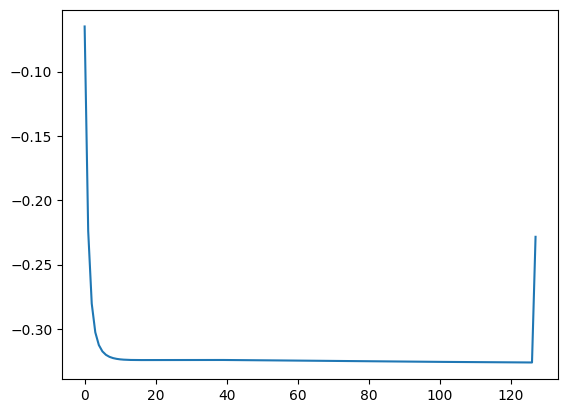

In [162]:
plt.plot(pred[0])

In [135]:
for inp,tar in val_dataset:
    t = np.squeeze(tar[0])
    break

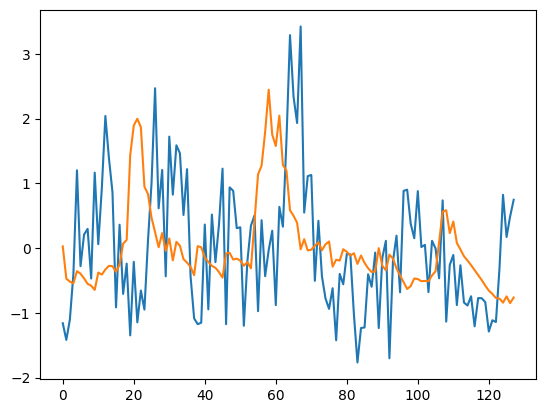

In [136]:
plt.plot(t)
plt.plot(pred[0])

In [116]:
t = np.expand_dims(t,axis=-1)

In [118]:
sum((pred[0]-(t+0.5))**2)

array([201.25641], dtype=float32)